# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Components-of-Learning" data-toc-modified-id="Components-of-Learning-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Components of Learning</a></div><div class="lev1 toc-item"><a href="#Linear-Regression-problem" data-toc-modified-id="Linear-Regression-problem-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Linear Regression problem</a></div><div class="lev1 toc-item"><a href="#Gradient-Descent" data-toc-modified-id="Gradient-Descent-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Gradient Descent</a></div><div class="lev2 toc-item"><a href="#Stochastic-gradient-descent-(SGD)" data-toc-modified-id="Stochastic-gradient-descent-(SGD)-31"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Stochastic gradient descent (SGD)</a></div><div class="lev1 toc-item"><a href="#Visualizing-gradient-descent" data-toc-modified-id="Visualizing-gradient-descent-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Visualizing gradient descent</a></div>

In [13]:
%matplotlib inline
import math,sys,os,numpy as np
import torch
from matplotlib import pyplot as plt, rcParams, animation, rc
from __future__ import print_function, division
from ipywidgets import interact, interactive, fixed
from ipywidgets.widgets import *
rc('animation', html='html5')
rcParams['figure.figsize'] = 3, 3
%precision 4
np.set_printoptions(precision=4, linewidth=100)

# Components of Learning

Pedro Domingos in a famous [paper](https://homes.cs.washington.edu/~pedrod/papers/cacm12.pdf) decomposes a learning problem in three components:

* **Representation**: The space of allowed models.
    * Example: (1) logistic regression, (2) 3-layer feedforward neural network
* **Evaluation**: How do you judge or prefer one model versus another. (loss function, utility function)
* **Optimization**: How do you search the space of models to obtain better evaluation.

In this part of the lecture we explain Stochastic Gradient Descent (SGD) which is an **optimization** method commonly used in neural networks. We will illustrate the concepts with concrete examples.

#  Linear Regression problem

The goal of linear regression is to fit a line to a set of points.

In [16]:
# Here we generate some fake data
def lin(a,b,x): return a*x+b

def gen_fake_data(n, a, b):
    x = s = np.random.uniform(0,1,n) 
    y = lin(a,b,x) + 0.1 * np.random.normal(0,3,n)
    return x, y

x, y = gen_fake_data(50, 3., 8.)

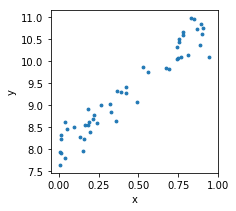

In [17]:
plt.scatter(x,y, s=8); plt.xlabel("x"); plt.ylabel("y"); 

You want to find **parameters** (weights) $a$ and $b$ such that you minimize the *error* between the points and the line $a\cdot x + b$. Note that here $a$ and $b$ are unknown. For a regression problem the most common *error function* or *loss function* is the **mean squared error**. 

In [22]:
def mean_square_error(y_hat, y):
    return np.power(y_hat - y, 2).mean()

Suppose we believe $a = 10$ and $b = 5$ then we can compute `y_hat` which is our *prediction* and then compute our error.

In [19]:
y_hat =  lin(10,5,x)

mean_square_error(y_hat, y)

5.0467

In [20]:
def mean_square_error_loss(a, b, x, y):
    y_hat =  lin(a,b,x)
    return np.power(y_hat - y, 2).mean()

In [21]:
mean_square_error_loss(10, 5, x, y)

5.0467

So far we have specified the *model representation* (linear regression) and the *evaluation criteria* (mean square error). We have not yet talk about the *optimization* part. That is, how do we find the best values for $a$ and $b$? How do we find the best *fitting* linear regression.

# Gradient Descent

For a fixed dataset $x$ and $y$ `mean_square_error_loss(a,b)` is a function of $a$ and $b$. We would like to find the values of $a$ and $b$ that minimize that function.

**Gradient descent** is an algorithm that minimizes functions. Given a function defined by a set of parameters, gradient descent starts with an initial set of parameter values and iteratively moves toward a set of parameter values that minimize the function. This iterative minimization is achieved by taking steps in the negative direction of the function gradient.

Here is gradient descent implemented in [PyTorch](http://pytorch.org/).

In [9]:
# generate some more data
x, y = gen_fake_data(10000, 3., 8.)

In [10]:
print(x.shape, y.shape)

(10000,) (10000,)


In [11]:
dtype = torch.cuda.FloatTensor

In [12]:
# from numpy to pytorch
x = torch.from_numpy(x)
y = torch.from_numpy(y)

In [53]:
from torch.autograd import Variable
# Create random Tensors to hold x and y, and wrap them in Variables.
# Setting requires_grad=False indicates that we do not need to compute gradients
# with respect to these Variables.
x = Variable(x.type(dtype), requires_grad=False)
y = Variable(y.type(dtype), requires_grad=False)

In [54]:
# Create random Tensors for weights a and b, and wrap them in Variables.
# Setting requires_grad=True indicates that we want to compute gradients with
# respect to these Variables.
a = Variable(torch.randn(1).type(dtype), requires_grad=True)
b = Variable(torch.randn(1).type(dtype), requires_grad=True)

a.grad = Variable(dtype(a.size()).zero_())
b.grad = Variable(dtype(b.size()).zero_())

In [55]:
a, b

(Variable containing:
 1.00000e-02 *
  -1.4499
 [torch.cuda.FloatTensor of size 1 (GPU 0)], Variable containing:
 -0.4470
 [torch.cuda.FloatTensor of size 1 (GPU 0)])

In [58]:
learning_rate = 1e-3
for t in range(10000):
    # Forward pass: compute predicted y using operations on Variables
    y_pred = x * a + b
    loss = (y_pred - y).pow(2).mean()
    if t % 1000 == 0: print(loss.data)
    
    # Manually zero the gradients
    a.grad.data.zero_()
    b.grad.data.zero_()    
    
    # Computes the gradient of loss with respect to all Variables with requires_grad=True.
    # After this call a.grad and b.grad will be Variables holding the gradient
    # of the loss with respect to a and b respectively.
    loss.backward()
    
    # Update a and b using gradient descent; a.data and b.data are Tensors,
    # a.grad and b.grad are Variables and a.grad.data and b.grad.data are
    # Tensors.
    a.data -= learning_rate * a.grad.data
    b.data -= learning_rate * b.grad.data


1.00000e-02 *
  9.6355
[torch.cuda.FloatTensor of size 1 (GPU 0)]


1.00000e-02 *
  9.4419
[torch.cuda.FloatTensor of size 1 (GPU 0)]


1.00000e-02 *
  9.2928
[torch.cuda.FloatTensor of size 1 (GPU 0)]


1.00000e-02 *
  9.1782
[torch.cuda.FloatTensor of size 1 (GPU 0)]


1.00000e-02 *
  9.0899
[torch.cuda.FloatTensor of size 1 (GPU 0)]


1.00000e-02 *
  9.0219
[torch.cuda.FloatTensor of size 1 (GPU 0)]


1.00000e-02 *
  8.9696
[torch.cuda.FloatTensor of size 1 (GPU 0)]


1.00000e-02 *
  8.9294
[torch.cuda.FloatTensor of size 1 (GPU 0)]


1.00000e-02 *
  8.8984
[torch.cuda.FloatTensor of size 1 (GPU 0)]


1.00000e-02 *
  8.8746
[torch.cuda.FloatTensor of size 1 (GPU 0)]



In [59]:
print(a, b)

Variable containing:
 3.0833
[torch.cuda.FloatTensor of size 1 (GPU 0)]
 Variable containing:
 7.9590
[torch.cuda.FloatTensor of size 1 (GPU 0)]



## Stochastic gradient descent (SGD)

Nearly all of deep learning is powered by one very important algorithm: **stochastic gradient descent(SGD)**. SGD can be seeing as an approximation of **gradient descent** (GD). In GD you have to run through *all* the samples in your training set to do a single itaration. In SGD you use *only one* or *a subset*  of training samples to do the update for a parameter in a particular iteration. The subset use in every iteration is called a **batch** or **minibatch**.

# Visualizing gradient descent

In [63]:
x, y = gen_fake_data(50, 3., 8.)

In [65]:
def sse(y,y_pred): return ((y-y_pred)**2).sum()
def loss(y,a,b,x): return sse(y, lin(a,b,x))
def avg_loss(y,a,b,x): return np.sqrt(loss(y,a,b,x)/y.shape[0])

In [66]:
a_guess=-1.
b_guess=1.
avg_loss(y, a_guess, b_guess, x)

9.1483

In [70]:
lr=0.01
def upd():
    global a_guess, b_guess
    y_pred = lin(a_guess, b_guess, x)
    dydb = 2 * (y_pred - y)
    dyda = x*dydb
    a_guess -= lr*dyda.mean()
    b_guess -= lr*dydb.mean()

In [71]:
fig = plt.figure(dpi=100, figsize=(5, 4))
plt.scatter(x,y)
line, = plt.plot(x,lin(a_guess,b_guess,x))
plt.close()

def animate(i):
    line.set_ydata(lin(a_guess,b_guess,x))
    for i in range(30): upd()
    return line,

ani = animation.FuncAnimation(fig, animate, np.arange(0, 40), interval=100)
ani